In [1]:
# importing libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
from matplotlib import pyplot as plt

import datetime

import statsmodels.formula.api as smf 
import statsmodels.api as sm  

import pickle

fin = open("/media/data/slavadoData/creds_mysql.txt", 'r')
creds = fin.read().split("\n")

In [2]:
import mysql.connector

mydb = mysql.connector.connect(
  host= creds[0],
  user= creds[1],
  passwd= creds[2]
)

print(mydb)

In [3]:
# Get data from 2017 to 2019; we exclude 2020 because it's an atypical year

query = "select * from d4c2020.all_ports_plus_vessels_alldates where `Data DD-MM-AAAA` >= '2017-01-01' and `Data DD-MM-AAAA` < '2020-01-01'"

df_raw = pd.read_sql(query, mydb)

In [4]:
df = df_raw.copy()
df.shape

(3717624, 17)

In [5]:
def lota_flag(lota):
    if 'Lota' in lota:
        return 'F/Lota'
    else:
        return 'Lota'
    
df['lota_flag'] = df['Nome Lota'].apply(lota_flag)

In [6]:
def nuts(val):
    
    if val in ['Albufeira', 'Lagos', 'Olhão', 'Portimão', 'Quarteira', 'Sagres', 'V.R.S. António',
              'Lagos/F Lota', 'Olhão/F Lota', 'Portimão/F Lota', 'Quarteira/F Lota', 'Sagres/F Lota', 
               'V.R.S. António/F Lota']:
        return 'Algarve'
    elif val in ['Sines', 'V.N.Milfontes', 'Sines/F Lota']:
        return 'Alentejo'
    elif val in ['Setúbal', 'Sesimbra', 'Costa da Caparica', 'Sesimbra/F Lota', 'Setúbal/F Lota']:
        return 'AML'
    elif val in ['Aveiro', 'Figueira da Foz', 'Mira', 'Nazaré', 'Peniche', 
                 'Aveiro/F Lota', 'Figueira da Foz/F Lota', 'Nazaré/F Lota', 'Peniche/F Lota']:
        return 'Centro'
    elif val in ['Matosinhos', 'Póvoa de Varzim', 'V. Praia de Âncora', 'Viana do Castelo', 'Vila do Conde', 
                'Matosinhos/F Lota', 'Póvoa de Varzim/F Lota', 'Viana do Castelo/F Lota']:
        return 'Norte'

df['nuts'] =  df['Nome Lota'].apply(nuts)

In [7]:
# group by species and region, calculating the total kgs fished, total revenue and average price/(kg)
avg_species = df.groupby(by = ['Nome Espécie', 'nuts']).agg({
                                            'kg': 'sum', 
                                            'prméd':'mean', 
                                            'euros': 'sum'}).reset_index()
avg_species.head()

,Nome Espécie,nuts,kg,prméd,euros
0,Abrotea-branca,AML,"10,143.60",3.78,"38,189.21"
1,Abrotea-branca,Algarve,3.60,4.85,17.46
2,Abrotea-branca,Centro,"4,760.00",2.08,"8,162.93"
3,Abrotea-da-costa,AML,"41,754.70",4.48,"181,147.82"
4,Abrotea-da-costa,Alentejo,"72,492.90",3.68,"284,361.31"


## Species with highest economic value

In [8]:
# Calculate the total revenue per region
total_euros = df.groupby(by = ['nuts']).agg({
                                            'euros': 'sum'}).reset_index()

total_euros.columns = ['nuts', 'total_euros']


# Merge total revenue to the original table aggregated by species and nuts
avg_species = avg_species.merge(total_euros, right_on = ['nuts'], left_on = ['nuts'])

In [29]:
# Calculate the % of the total revenues that corresponds to each species 

avg_species['euros_perc_total'] = avg_species['euros']/avg_species['total_euros']*100

# Sort by the revenue
avg_species = avg_species.sort_values(['nuts', 'euros'], ascending = False)

# Calculate the cumulative sum of the percentage
avg_species['cumulative_sum'] = avg_species.groupby(['nuts'])['euros_perc_total'].cumsum()

# Select the species that cumulatively correspond to 70% of the revenue
econ_species_sel = avg_species[(avg_species['cumulative_sum'] <= 71)]
econ_species_sel.columns = ['Nome Espécie', 'Região', 'total_kgs_espécie', 'preço_kg_espécie', 
                          'total_euros_espécie', 'total_euros_região', '%_total_euros', '%_acumulada']


econ_species_sel[econ_species_sel['Região'] == 'Algarve']

,Nome Espécie,Região,total_kgs_espécie,preço_kg_espécie,total_euros_espécie,total_euros_região,%_total_euros,%_acumulada
352,Polvo-vulgar,Algarve,"3,088,545.50",7.41,"22,532,265.94","60,629,651.82",37.16,37.16
267,Choco-vulgar,Algarve,"619,589.30",7.04,"4,088,346.37","60,629,651.82",6.74,43.91
277,Dourada,Algarve,"252,970.90",11.15,"2,418,587.29","60,629,651.82",3.99,47.90
383,Salmonete-legitimo,Algarve,"138,286.60",17.08,"2,408,731.24","60,629,651.82",3.97,51.87
272,Corvina-legitima,Algarve,"214,113.70",10.67,"2,227,712.00","60,629,651.82",3.67,55.54
219,Azevias,Algarve,"202,681.40",11.61,"2,217,626.11","60,629,651.82",3.66,59.20
403,Tamboril-preto,Algarve,"212,351.40",7.98,"1,678,784.57","60,629,651.82",2.77,61.97
335,Pargo-legitimo,Algarve,"82,462.60",16.71,"1,399,607.40","60,629,651.82",2.31,64.28
310,Linguado-legítimo,Algarve,"80,427.10",15.92,"1,271,541.25","60,629,651.82",2.10,66.38
391,Sargo-legitimo,Algarve,"147,312.90",7.94,"1,159,007.12","60,629,651.82",1.91,68.29


In [14]:
def plot_species_econ(region):

    labels = list(econ_species_sel[econ_species_sel['Região'] == region]['Nome Espécie'])

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,7))
    rects1 = ax.bar(x - width, econ_species_sel[econ_species_sel['Região'] == region]['preço_kg_espécie'], width, label='Preço médio', color = '#f3512e')
    rects2 = ax.bar(x, econ_species_sel[econ_species_sel['Região'] == region]['total_kgs_espécie']/100000, width, label='Volume total', color = '#00b3f6')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Kgs (centenas de toneladas)/preço médio', fontsize=14)
    ax.set_title('Espécies com maior peso económico | ' + region, fontsize=14)
    plt.xticks(x, labels, rotation='vertical', fontsize=12)
    ax.set_xticklabels(labels, fontsize=14)
    ax.legend()

    plt.xticks(rotation = 90)

    #fig.tight_layout()

    plt.show()

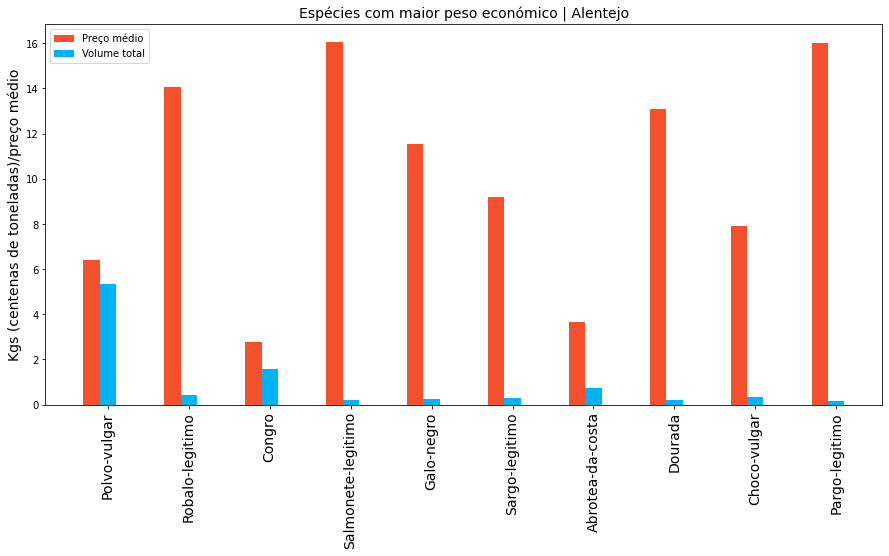

In [15]:
plot_species_econ('Alentejo')

In [24]:
# Write to csv, to be used in subsequent analysis
#econ_species_sel.to_csv('species_highest_economic_weight_region.csv')

## Most valued species selection

In [16]:
# Calculate average price per kg, per NUT

mean_price = pd.DataFrame(avg_species.groupby(['nuts']).prméd.mean()).reset_index()
mean_price

,nuts,prméd
0,AML,5.92
1,Alentejo,5.91
2,Algarve,7.05
3,Centro,5.84
4,Norte,4.65


In [17]:
# Calculate average total volume (kg), per NUT

mean_kgs = pd.DataFrame(avg_species.groupby(['nuts']).kg.mean()).reset_index()
mean_kgs

,nuts,kg
0,AML,"83,091.16"
1,Alentejo,"12,900.93"
2,Algarve,"46,276.54"
3,Centro,"54,713.74"
4,Norte,"35,785.11"


In [26]:
avg_species[(avg_species['nuts'] == 'AML') & (avg_species['Nome Espécie'] == 'Amêijoa-japonesa')].sort_values('prméd', ascending=False)

,Nome Espécie,nuts,kg,prméd,euros,total_euros,euros_perc_total,cumulative_sum
7,Amêijoa-japonesa,AML,"2,030,355.80",2.91,"2,741,511.63","53,792,711.78",5.10,50.17


In [28]:
# Select the species that combine a total volume (kgs) above average a price/kg above average

def most_valued_list(avg_species, region):
    
    most_valued_lota_df = avg_species[(avg_species['nuts'] == region) &
                                      (avg_species['prméd'] >= mean_price[(mean_price['nuts'] == region)].prméd.values[0]) & 
                                      (avg_species['kg'] >= mean_kgs[(mean_kgs['nuts'] == region)].kg.values[0])]

    return most_valued_lota_df.sort_values('prméd', ascending = False)
    

   
val_list = most_valued_list(avg_species, 'Norte')


for nut in ['Centro', 'AML', 'Alentejo', 'Algarve']:

    val_list = pd.concat([val_list, most_valued_list(avg_species, nut)], axis=0)
    
val_list[val_list['nuts'] == 'Algarve']

,Nome Espécie,nuts,kg,prméd,euros,total_euros,euros_perc_total,cumulative_sum
383,Salmonete-legitimo,Algarve,"138,286.60",17.08,"2,408,731.24","60,629,651.82",3.97,51.87
335,Pargo-legitimo,Algarve,"82,462.60",16.71,"1,399,607.40","60,629,651.82",2.31,64.28
374,Robalo-legitimo,Algarve,"48,409.90",16.03,"798,262.52","60,629,651.82",1.32,74.33
310,Linguado-legítimo,Algarve,"80,427.10",15.92,"1,271,541.25","60,629,651.82",2.10,66.38
288,Galo-negro,Algarve,"50,388.80",15.34,"803,762.78","60,629,651.82",1.33,73.02
349,Perceve,Algarve,"60,082.10",13.40,"796,523.27","60,629,651.82",1.31,75.65
218,Azevia-raiada,Algarve,"65,322.70",11.65,"759,890.59","60,629,651.82",1.25,76.90
219,Azevias,Algarve,"202,681.40",11.61,"2,217,626.11","60,629,651.82",3.66,59.20
277,Dourada,Algarve,"252,970.90",11.15,"2,418,587.29","60,629,651.82",3.99,47.90
272,Corvina-legitima,Algarve,"214,113.70",10.67,"2,227,712.00","60,629,651.82",3.67,55.54


In [20]:
def plot_species_val(region):

    labels = list(val_list[val_list['nuts'] == region]['Nome Espécie'])

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,7))
    rects1 = ax.bar(x - width, val_list[val_list['nuts'] == region]['prméd'], width, label='Preço médio', color = '#f3512e')
    rects2 = ax.bar(x, val_list[val_list['nuts'] == region]['kg']/100000, width, label='Volume total', color = '#00b3f6')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Kgs (centenas de toneladas)/preço médio', fontsize=14)
    ax.set_title('Espécies mais valorizadas no ' + region, fontsize=14)
    plt.xticks(x, labels, rotation='vertical', fontsize=12)
    ax.set_xticklabels(labels, fontsize=14)
    ax.legend()

    plt.xticks(rotation = 90)

    #fig.tight_layout()

    plt.show()

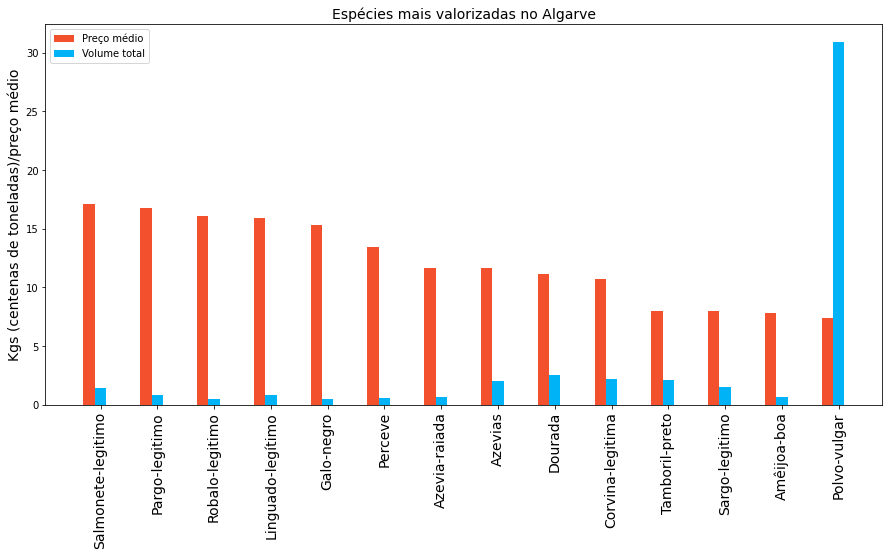

In [21]:
plot_species_val('Algarve')

In [45]:
# Write to csv, to be used in subsequent analysis
#val_list.to_csv('most_valued_species.csv')